In [1]:
import math
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10 #50k training images, 10k Testing images and 10 classes
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

Using TensorFlow backend.


In [2]:
train,test = cifar10.load_data()

170500096/170498071 [==============================] - 3673s 22us/step


In [3]:
X_train_orig,Y_train_orig = train

In [4]:
X_test_orig,Y_test_orig = test

In [5]:
Y_train_orig

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
def convert_to_one_hot(Y,num_classes):
    OHY = []
    for i in Y:
        OH = [0]*num_classes
        OH[i[0]] = 1
        OHY.append(OH)
    return np.array(OHY)

In [9]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 10)
Y_test = convert_to_one_hot(Y_test_orig, 10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


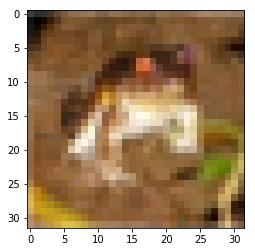

In [10]:
plt.imshow(X_train[0]) #CLASS 6 ie FROG

In [11]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [12]:
X, Y = create_placeholders(32, 32, 3, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [13]:
def initialize_parameters():
    
    tf.set_random_seed(1)   
    #W1 and W2 are filters where list given is [filter height, width, in_channels, out_channels]
    W1 = tf.get_variable("W1", [3, 3, 3, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [14]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.03386055  0.13702913 -0.12583864  0.01131533 -0.01675362  0.13317107
  0.05913341 -0.01099928 -0.04858302 -0.03004996  0.05836764  0.00666472
 -0.0723493  -0.12620732  0.05443153  0.1145436   0.11179502 -0.13286938
  0.06119993  0.06487656 -0.11156854  0.0972205   0.05960876 -0.11502925
 -0.04472959 -0.04024999  0.02190211  0.13032983  0.05584088 -0.06573811
 -0.1230271   0.12293662]
W2 = [ 0.07906965  0.00133786  0.00061651 -0.07879215  0.02750168  0.02304045
  0.03488332 -0.01292276 -0.03191449 -0.00492561 -0.06494135 -0.00490731
 -0.02308754  0.02074216 -0.04760901 -0.0164997  -0.07637173  0.03322452
 -0.03034306  0.05258862 -0.08127    -0.00078529  0.04894615  0.06827346
 -0.00478047 -0.00178114  0.05707899  0.08020826 -0.01779035  0.07015581
  0.06689543  0.01260801  0.05170222  0.005853    0.05865159  0.01147598
  0.02971029 -0.03328343 -0.08313584  0.04900313 -0.04857898 -0.0832473
 -0.01547464  0.00623184  0.06493057 -0.08269201  0.04597474  0.05370039
  0.03378846  0.

In [15]:
def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1, 1 ,1 ,1],padding='SAME')
    
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL: window 4x4, sride 4, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    
    # RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2,10, activation_fn=None)

    return Z3

In [16]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32, 32, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,32,32,3), Y: np.random.randn(2,10)})
    print("Z3 = " + str(a))

Z3 = [[ 0.0226949   0.6031482  -0.18882626  0.10354113  0.2566406  -0.10724551
   0.1704179   0.05320752 -0.23974992  0.0526712 ]
 [-0.45579493  0.37739632  0.1477898   0.17059144  0.02460591 -0.24527122
   0.1009794  -0.15119354 -0.7137847   0.16749844]]


In [17]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
    
    return cost

In [18]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32, 32, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,32,32,3), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = 3.8805327


In [19]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    """

    Creates a list of random minibatches from (X, Y)

    

    Arguments:

    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)

    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)

    mini_batch_size - size of the mini-batches, integer

    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    

    Returns:

    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)

    """

    

    m = X.shape[0]                  # number of training examples

    mini_batches = []

    np.random.seed(seed)            #the batches remain same on each device

    

    # Step 1: Shuffle (X, Y)

    permutation = list(np.random.permutation(m))       #shuffling 

    shuffled_X = X[permutation,:,:,:]

    shuffled_Y = Y[permutation,:]



    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.

    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning

    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]

        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]

        mini_batch = (mini_batch_X, mini_batch_Y)

        mini_batches.append(mini_batch)

    

    # Handling the end case (last mini-batch < mini_batch_size)

    if m % mini_batch_size != 0:          #if  the batch size is not completely divisible by the number of elements

        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]

        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]

        mini_batch = (mini_batch_X, mini_batch_Y)

        mini_batches.append(mini_batch)

    

    return mini_batches

In [20]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=50, minibatch_size=64, print_cost=True):     #after every ten iterations the cost gets printed
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             #tuple unpacking
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost to  represent on the graph later
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)  #placeholders are empty containers

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)             #does not run here since X is still empty
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.                       #stores the mean of all the mini batch costs 
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch       #unpacking of a tuple 
                
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})    #_ represents the function is just called but the value of the function is not stoed in a variable
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))      #if one of the axis is not labelled  then it displays the index of the only list passed 
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        try:
            # Calculate the correct predictions
            predict_op = tf.argmax(Z3, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))    #  converts true==1 and false==0
            print(accuracy)
            #train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
            #print("Train Accuracy:", train_accuracy)
            print("Test Accuracy:", test_accuracy)
        except:
            print('Memory Full, cannot process accuracy')
            test_accuracy = None
                
        return test_accuracy,parameters

In [ ]:
test_accuracy,parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1.497363


In [ ]:
#INCREASE NUMBER OF EPOCHS FOR BETTER TEST ACCURACY